# Model Inference

Here we will go through the steps needed to fit the behavioural model to the empirical data. This entails determining the posterior beliefs over model parameters and mini-block specific planning depth.

## 1. Data Import and Preparation

In [ ]:
import torch
from scipy import io
import pandas as pd
from torch import zeros, ones
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import getcwd, path, chdir
from pathlib import Path
from datetime import datetime
import glob
from scipy.stats import pearsonr


date = datetime.today().strftime('%Y-%m-%d')
groups = ["HC_match_all","HC_match_AUD_only", "HC_match_TUD_only", "HC_match_AUD_and_TUD", "AUD_only", 
          "TUD_only", "AUD_and_TUD"] # again "defined" below when concatenating groups' pars_dfs AND groups' mini-block-wise dfs
group_ids = [0,10,11,12,20,21,22]    # indication for statistics
translation_dict = dict(zip(groups, group_ids))

# set paths
homedir = path.expanduser("~")
reppath = path.join(homedir,"plandepth_aud_tud") # TODO: change to your individual path to the repository
datadir = path.join(reppath,"data")

datadir_hc  =  path.join(datadir,"HC")  # TODO: change to correct paths if necessary
datadir_aud =  path.join(datadir,"AUD_only")   
datadir_tud =  path.join(datadir,"TUD_only")
datadir_aud_tud =  path.join(datadir,"AUD_and_TUD")

# paths of models
fitdir_full                = path.join(datadir, "PosteriorSamples", "2025-01-29_full_planning")            # full planning (no alpha)
fitdir_LPP                 = path.join(datadir, "PosteriorSamples", "2025-02-02_LPP")                      # low probability pruning (1P, no alpha)
fitdir_probDiscounting     = path.join(datadir, "PosteriorSamples", "2025-02-02_probDiscounting")          # probability discounting (main transition discounting -> kappa_neutral = 0)
fitdir_LPP_probDiscounting = path.join(datadir, "PosteriorSamples", "2025-02-03_LPP_and_probDiscounting")  # low probability pruning + probability discounting (1P, no alpha, kappa_neutral = 0)

fitdir_full_with_alpha     = path.join(datadir, "PosteriorSamples", "2025-01-31_full_planning_with_alpha") # 'old' model (full planning with learning rate alpha) for vizualization of fit improvement through omitting alpha


chdir(reppath)
from helpers import map_noise_to_values, errorplot, load_and_format_SAT_data, mean_str

# set plotting params
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette("tab10")
palette_colors = sns.color_palette("tab10")
plt.rcParams.update({'axes.titlesize':  16,
                     'axes.labelsize': 15,
                     'xtick.labelsize': 13,
                     'ytick.labelsize': 12})

# load exclusion ids
filepath = path.join(datadir, "exclusion_ids.csv")
exclusion_ids = pd.read_csv(filepath,dtype={'ID':object}).ID.to_list()

# load matched ids
filepath = path.join(datadir, "matched_ids.csv")
df_matched_ids = pd.read_csv(filepath, dtype={'ID':object, 'matched_ID':object})

matched_hc_ids_all     = df_matched_ids.matched_ID.unique()
matched_hc_ids_aud     = df_matched_ids[df_matched_ids.group=='AUD_only'].matched_ID.unique()
matched_hc_ids_tud     = df_matched_ids[df_matched_ids.group=='TUD_only'].matched_ID.unique()
matched_hc_ids_aud_tud = df_matched_ids[df_matched_ids.group=='AUD_and_TUD'].matched_ID.unique()

In [6]:
# load and format behavioural data

filenames = ["space_adventure_pd-results.json",
             "space_adventure_pd_inv-results.json"]    # posible filenames of SAT logfiles

# load groups (HC group contains all subs, including matched and unmatched)
stimuli_hc,      mask_hc,      responses_hc,      rts_hc,      scores_hc,      conditions_hc,      ids_hc,      bal_hc,      noTrainings_hc      = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids)
stimuli_aud,     mask_aud,     responses_aud,     rts_aud,     scores_aud,     conditions_aud,     ids_aud,     bal_aud,     noTrainings_aud     = load_and_format_SAT_data(datadir_aud,     filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids)
stimuli_tud,     mask_tud,     responses_tud,     rts_tud,     scores_tud,     conditions_tud,     ids_tud,     bal_tud,     noTrainings_tud     = load_and_format_SAT_data(datadir_tud,     filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids)
stimuli_aud_tud, mask_aud_tud, responses_aud_tud, rts_aud_tud, scores_aud_tud, conditions_aud_tud, ids_aud_tud, bal_aud_tud, noTrainings_aud_tud = load_and_format_SAT_data(datadir_aud_tud, filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids)

# load matched subgroups of HC group
stimuli_hc_m_a,  mask_hc_m_a,  responses_hc_m_a,  rts_hc_m_a,  scores_hc_m_a,  conditions_hc_m_a,  ids_hc_m_a,  bal_hc_m_a,  noTrainings_hc_m_a  = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids, inclusion_ids=matched_hc_ids_aud)
stimuli_hc_m_t,  mask_hc_m_t,  responses_hc_m_t,  rts_hc_m_t,  scores_hc_m_t,  conditions_hc_m_t,  ids_hc_m_t,  bal_hc_m_t,  noTrainings_hc_m_t  = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids, inclusion_ids=matched_hc_ids_tud)
stimuli_hc_m_at, mask_hc_m_at, responses_hc_m_at, rts_hc_m_at, scores_hc_m_at, conditions_hc_m_at, ids_hc_m_at, bal_hc_m_at, noTrainings_hc_m_at = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids, inclusion_ids=matched_hc_ids_aud_tud)

# load matched HC group pooled over all matched subgroups
stimuli_hc_m,    mask_hc_m,    responses_hc_m,    rts_hc_m,    scores_hc_m,    conditions_hc_m,    ids_hc_m,    bal_hc_m,    noTrainings_hc_m    = load_and_format_SAT_data(datadir_hc,      filenames, discard_training_blocks=False, exclusion_ids = exclusion_ids, inclusion_ids=matched_hc_ids_all)


## 2. Model Comparison

Comparison of 4 computational models for planning task:
- full planning
- low probability pruning
- probability discounting
- low probability pruning with prob. discounting

In [16]:
# load model fit measures
df_fit_full                = pd.read_csv(path.join(fitdir_full, 'model_fits.csv'), dtype={"ID":object})
df_fit_LPP                 = pd.read_csv(path.join(fitdir_LPP, 'model_fits.csv'), dtype={"ID":object})
df_fit_probDiscounting     = pd.read_csv(path.join(fitdir_probDiscounting, 'model_fits.csv'), dtype={"ID":object})
df_fit_LPP_probDiscounting = pd.read_csv(path.join(fitdir_LPP_probDiscounting, 'model_fits.csv'), dtype={"ID":object})
df_fit_with_alpha          = pd.read_csv(path.join(fitdir_full_with_alpha, 'model_fits.csv'), dtype={"ID":object})

# add model col
df_fit_full['model']                = "full planning"                # full planning (no learning rate)
df_fit_LPP['model']                 = "low-probability pruning"      # low probability pruning (1P, no learning rate)
df_fit_probDiscounting['model']     = "discounted full planning"     # probability discounting (no learning rate)
df_fit_LPP_probDiscounting['model'] = "discounted low-prob. pruning" # low probability pruning + probability discounting (1P, no learning rate)
df_fit_with_alpha['model']          = "full planning with alpha"     # full planning with alpha (old model for comparison)

# labels
noise_order = ['low','high']

# concat relevant dfs for model comparison
model_order     = ["full planning", "low-probability pruning",  "discounted full planning",  "discounted low-prob. pruning"]
model_labels    = ["full planning", "low-probability pruning",  "discounted full planning",  "discounted low-prob. pruning"]
df_fit = pd.concat([df_fit_full,      df_fit_LPP,  df_fit_probDiscounting,  df_fit_LPP_probDiscounting])

# concat dfs for vizualization of fit improvement through omitting alpha
model_order_alpha     = ["full planning with alpha", "full planning"]
model_labels_alpha    = ["full planning with alpha", "full planning"]
df_fit_alpha = pd.concat([df_fit_with_alpha, df_fit_full])

### transform dfs for plotting
fit_groups = ['HC_match_all', 'AUD_only', 'TUD_only', 'AUD_and_TUD']
fit_groups_labels = ['Matched HC', 'AUD', 'TUD', 'AUD and TUD']

def create_plot_dfs(df_fit, model_order, null_model="full planning"):
    df_fit_sbj = df_fit[df_fit.group.isin(fit_groups)].groupby(by=['ID','group','model'], as_index=False).mean()
    # df for WAIC differences per noise condition with null model "full planning"
    tmp  = df_fit_sbj.pivot(index=['ID','group'], columns='model', values=['WAIC_low','WAIC_high'])
    df_list = []
    for b in ['WAIC_low','WAIC_high']:
        tmp2 = tmp.reset_index()[['ID','group']].droplevel('model',axis=1)
        for i,m in enumerate(model_order[1:]):
            tmp2['noise'] = b[5:]
            tmp2['model1'] = model_order[0]
            tmp2[m]  =  tmp.loc[:,(b,null_model)].values  -  tmp.loc[:,(b,m)].values
        df_list.append(tmp2)
    df_fit_sbj_diffs_noise = pd.melt(pd.concat(df_list), id_vars=["ID","group","noise","model1"], value_vars=model_order[1:], var_name='model2', value_name='WAIC_Diff_m1-m2')
    df_fit_sbj_diffs_noise = df_fit_sbj_diffs_noise[df_fit_sbj_diffs_noise.model2 != null_model]  # remove null model
    df_fit_sbj_diffs = df_fit_sbj_diffs_noise.groupby(by=['ID','group','model1','model2'], as_index=False).sum() # aggregate differences (WAIC has to be summed up over data points)
  
    # df for model fits per noise condition and model
    df_fit_sbj_noise = pd.melt(df_fit_sbj, id_vars=["ID","group","model"], value_vars=['WAIC_high','WAIC_low'], var_name='noise', value_name='WAIC')
    df_fit_sbj_noise.noise = df_fit_sbj_noise.noise.str.slice(5)

    # df for model fits per model
    df_fit_sbj = df_fit_sbj_noise.groupby(by=['ID','group','model'], as_index=False).agg({'WAIC':'sum'})  # aggregate noise-wise fit measures (WAIC has to be summed up over data points)
    return df_fit_sbj, df_fit_sbj_diffs, df_fit_sbj_noise, df_fit_sbj_diffs_noise

for tmp in [df_fit, df_fit_alpha]:
    tmp.rename(columns={'WAIC':'WAIC_sum',
                        'WAIC_highNoise':'WAIC_high',
                        'WAIC_lowNoise':'WAIC_low',
                        'pseudo_Rsquare_1staction_mean':'pseudo_Rsquare_mean',
                        'pseudo_Rsquare_1staction_hinoise_mean':'pseudo_Rsquare_high',
                        'pseudo_Rsquare_1staction_lonoise_mean':'pseudo_Rsquare_low'}, inplace=True)

null_model = "full planning"
df_fit_sbj, df_fit_sbj_diffs, df_fit_sbj_noise, df_fit_sbj_diffs_noise = create_plot_dfs(df_fit, model_order=model_order, null_model=null_model)
null_model_alpha = "full planning with alpha"
df_fit_sbj_alpha, df_fit_sbj_diffs_alpha, df_fit_sbj_noise_alpha, df_fit_sbj_diffs_noise_alpha = create_plot_dfs(df_fit_alpha, model_order=model_order_alpha, null_model=null_model_alpha)


In [17]:
# load model_fits_waicPerMb.csv

# model_order from above

df_fit_mbs_waic_full                      = pd.read_csv(path.join(fitdir_full,  'model_fits_waicPerMb.csv'), dtype={"ID":object})
df_fit_mbs_waic_LPP                       = pd.read_csv(path.join(fitdir_LPP,  'model_fits_waicPerMb.csv'), dtype={"ID":object})
df_fit_mbs_waic_probDiscounting           = pd.read_csv(path.join(fitdir_probDiscounting,  'model_fits_waicPerMb.csv'), dtype={"ID":object})
df_fit_mbs_waic_LPP_and_probDiscounting   = pd.read_csv(path.join(fitdir_LPP_probDiscounting,  'model_fits_waicPerMb.csv'), dtype={"ID":object})

df_fit_mbs_waic_full['model']                    = "full planning"
df_fit_mbs_waic_LPP['model']                     = "low-probability pruning"
df_fit_mbs_waic_probDiscounting['model']         = "discounted full planning"
df_fit_mbs_waic_LPP_and_probDiscounting['model'] = "discounted low-prob. pruning"

# add noise col
df_fit_mbs_waic_full['noise']                      = conditions_hc_m[0,0,df_fit_mbs_waic_full['block_num'].values-1]  # noise is the same for all models
df_fit_mbs_waic_LPP['noise']                       = conditions_hc_m[0,0,df_fit_mbs_waic_LPP['block_num'].values-1]
df_fit_mbs_waic_probDiscounting['noise']           = conditions_hc_m[0,0,df_fit_mbs_waic_probDiscounting['block_num'].values-1]
df_fit_mbs_waic_LPP_and_probDiscounting['noise']   = conditions_hc_m[0,0,df_fit_mbs_waic_LPP_and_probDiscounting['block_num'].values-1]

df_fit_mbs_waic = pd.concat([df_fit_mbs_waic_full, df_fit_mbs_waic_LPP, df_fit_mbs_waic_probDiscounting, df_fit_mbs_waic_LPP_and_probDiscounting])

# compute differences in WAIC for each miniblock and ID between each model and the null model (full_trueP_fixed)
df_fit_mbs_waic_diffs = df_fit_mbs_waic.pivot(index=['ID','group','block_num','noise'], columns='model', values=['WAIC_pointwise']).reset_index()
df_list = []
for m in model_order[1:]:
    tmp2 = df_fit_mbs_waic_diffs[['ID','group','block_num','noise']].copy()
    tmp2['model1'] = model_order[0]
    tmp2['model2'] = m
    tmp2['WAIC_perMb_Diff_m1-m2']  =  df_fit_mbs_waic_diffs.loc[:,('WAIC_pointwise',null_model)].values  -  df_fit_mbs_waic_diffs.loc[:,('WAIC_pointwise',m)].values
    df_list.append(tmp2)

df_fit_mbs_waic_diffs = pd.concat(df_list).droplevel(1,axis=1)

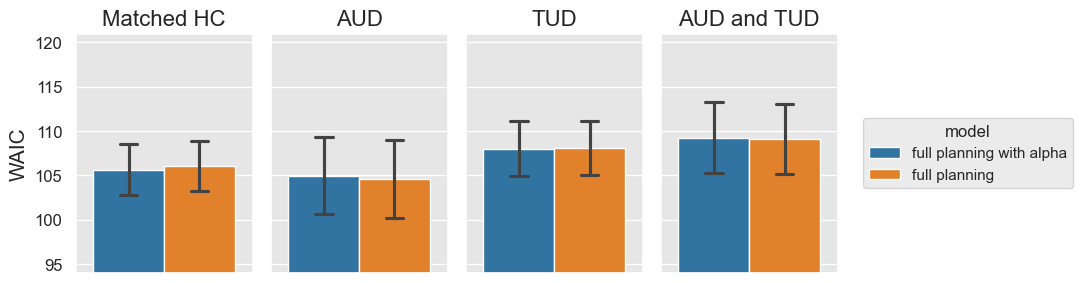

In [18]:
# vizualization of model fit robustness despite omitting alpha with sbj-averaged model-fits (WAIC, the lower the better) per group

fig, axes = plt.subplots(1,4, sharey=True, figsize=(11,3))

for i in range(4):
    legend = False if i<3 else True
    g = sns.barplot(ax=axes[i], data=df_fit_sbj_alpha[df_fit_sbj_alpha.group==fit_groups[i]], y='WAIC', hue='model', legend = legend, errorbar='se', capsize=.2, hue_order=model_order_alpha)
    axes[i].set_title(fit_groups_labels[i])

axes[0].set_ylim([94,121])

sns.move_legend(axes[-1], loc="center left", bbox_to_anchor=(1.1, 0.5), labels=model_labels_alpha)

plt.tight_layout()
fig.savefig('model_fits_WAIC_groups_alpha.png', dpi=300, bbox_inches = 'tight')

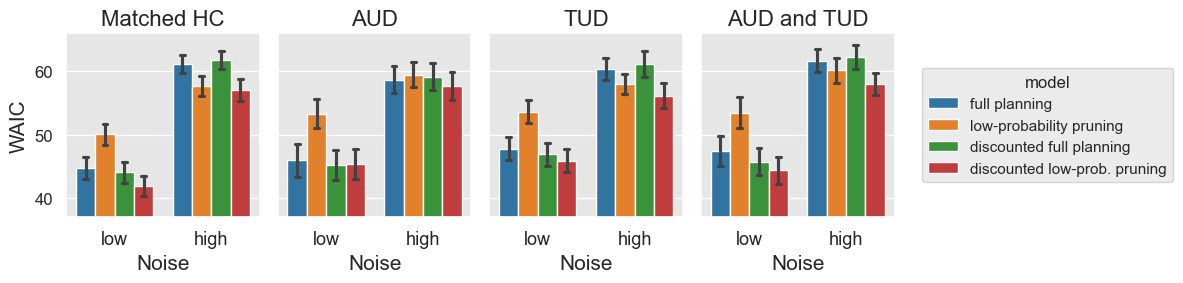

In [19]:
# sbj-averaged model-fits (WAIC, the lower the better) per group and condition

fig, axes = plt.subplots(1,4, sharey=True, figsize=(12,3))

for i in range(4):
    legend = False if i<3 else True
    g = sns.barplot(ax=axes[i], data=df_fit_sbj_noise[df_fit_sbj_noise.group==fit_groups[i]], x='noise', y='WAIC', hue='model', legend = legend, errorbar='se', capsize=.2, order=noise_order, hue_order=model_order)
    axes[i].set_title(fit_groups_labels[i])
    axes[i].set_xlabel('Noise')
    
axes[0].set_ylim([37,66])

sns.move_legend(axes[-1], loc="center left", bbox_to_anchor=(1.1, 0.5), labels=model_labels)

plt.tight_layout()
#fig.savefig('model_fits_WAIC_noise.png', dpi=300, bbox_inches = 'tight')

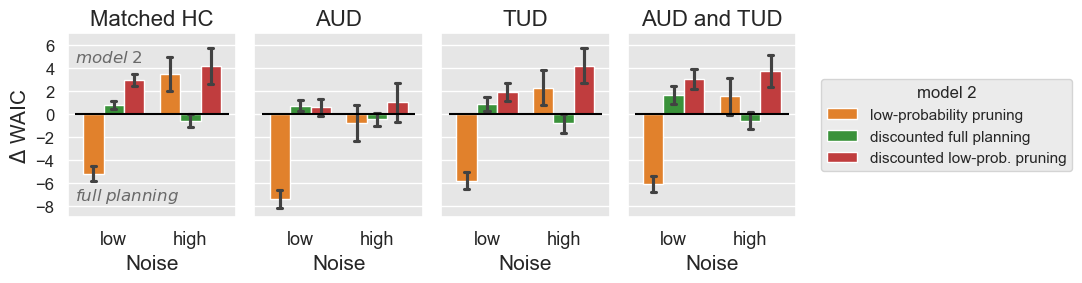

In [20]:
# Differences of sbj-averaged WAIC values per noise condition (WAIC_fullPlanning - WAIC_2) per group

fig, axes = plt.subplots(1,4, sharey=True, figsize=(11,3))

n_models = len(model_order)

for i in range(4):
    legend = False if i<3 else True

    g = sns.barplot(ax=axes[i], data=df_fit_sbj_diffs_noise[df_fit_sbj_diffs_noise.group==fit_groups[i]], x='noise', y='WAIC_Diff_m1-m2', hue='model2', legend = legend, errorbar='se', capsize=.2, order=noise_order, hue_order=model_order[1:], palette=palette_colors[1:n_models])
    axes[i].set_title(fit_groups_labels[i])
    axes[i].set_xlabel('Noise')
    xmin, xmax = axes[i].get_xlim()
    axes[i].hlines(0, xmin, xmax, colors='black')

axes[0].set_yticks(np.arange(-8,8.5,2))
axes[0].set_ylim(-9,7)
axes[0].set_ylabel(r'$\Delta$ WAIC')
axes[0].text(-0.5,4.5,  r'$\it{model}$'+' '+r'$\it{2}$', color='dimgray')
axes[0].text(-0.5,-7.5, r'$\it{full}$'+' '+r'$\it{planning}$', color='dimgray')
#fig.suptitle('Model Comparisons (WAIC_full_planning - WAIC_model_2)')

sns.move_legend(axes[-1], loc="center left", bbox_to_anchor=(1.1, 0.5), title="model 2", labels=model_labels[1:])

plt.tight_layout()
#fig.savefig('model_fits_WAIC_diffs_noise.png', dpi=300, bbox_inches = 'tight')

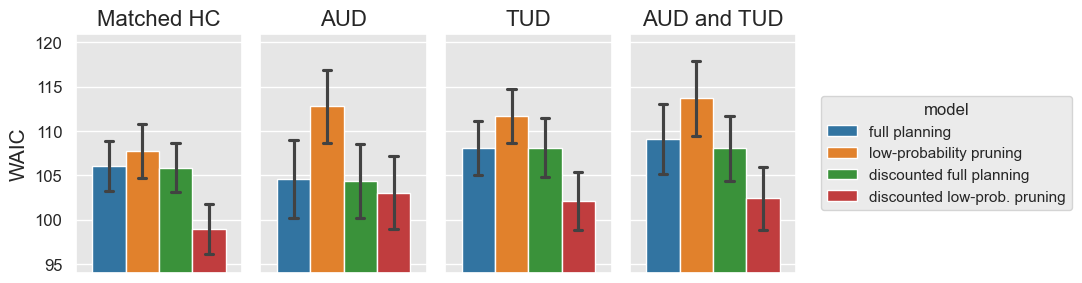

In [21]:
# sbj-averaged model-fits (WAIC, the lower the better) per group

fig, axes = plt.subplots(1,4, sharey=True, figsize=(11,3))

for i in range(4):
    legend = False if i<3 else True
    g = sns.barplot(ax=axes[i], data=df_fit_sbj[df_fit_sbj.group==fit_groups[i]], y='WAIC', hue='model', legend = legend, errorbar='se', capsize=.2, hue_order=model_order)
    axes[i].set_title(fit_groups_labels[i])

axes[0].set_ylim([94,121])

sns.move_legend(axes[-1], loc="center left", bbox_to_anchor=(1.1, 0.5), labels=model_labels)

plt.tight_layout()
#fig.savefig('model_fits_WAIC_groups.png', dpi=300, bbox_inches = 'tight')

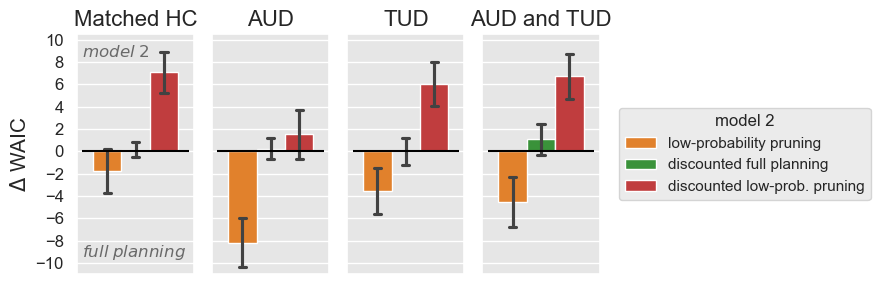

In [22]:
# Differences of sbj-averaged WAIC values per group (WAIC_fullPlanning - WAIC_2)

fig, axes = plt.subplots(1,4, sharey=True, figsize=(9,3))

n_models = len(model_order)

for i in range(4):
    legend = False if i<3 else True

    g = sns.barplot(ax=axes[i], data=df_fit_sbj_diffs[df_fit_sbj_diffs.group==fit_groups[i]], y='WAIC_Diff_m1-m2', hue='model2', legend = legend, errorbar='se', capsize=.2, hue_order=model_order[1:], palette=palette_colors[1:n_models])
    axes[i].set_title(fit_groups_labels[i])
    xmin, xmax = axes[i].get_xlim()
    axes[i].hlines(0, xmin, xmax, colors='black')

axes[0].set_yticks(np.arange(-10,11,2))
axes[0].set_ylim(-11,10.5)
axes[0].set_ylabel(r'$\Delta$ WAIC')
axes[0].text(-0.5,8.5,  r'$\it{model}$'+' '+r'$\it{2}$', color='dimgray')
axes[0].text(-0.5,-9.45, r'$\it{full}$'+' '+r'$\it{planning}$', color='dimgray')
#fig.suptitle('Model Comparisons (WAIC_full_planning - WAIC_model_2)')

sns.move_legend(axes[-1], loc="center left", bbox_to_anchor=(1.1, 0.5), title="model 2", labels=model_labels[1:])

plt.tight_layout()
#fig.savefig('model_fits_WAIC_diffs_groups.png', dpi=300, bbox_inches = 'tight')

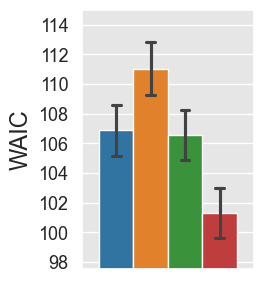

In [ ]:
# sbj-averaged model-fits (WAIC, the lower the better) all groups merged
fig = plt.figure(figsize=(2.8,3));

# set plotting params
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette("tab10")
palette_colors = sns.color_palette("tab10")
plt.rcParams.update({'axes.titlesize':  16,
                     'axes.labelsize': 17,
                     'xtick.labelsize': 13,
                     'ytick.labelsize': 13})


g = sns.barplot(data=df_fit_sbj, y='WAIC', hue='model', errorbar='se', capsize=.2, hue_order=model_order, legend=False)
g.set_ylim([97.5, 115])
g.set_yticks(np.arange(98,115,2))
#sns.move_legend(g, loc="center left", bbox_to_anchor=(1.1, 0.5), labels=model_labels)

plt.tight_layout();
fig.savefig('model_fits_WAIC_overall.png', dpi=300, bbox_inches = 'tight');

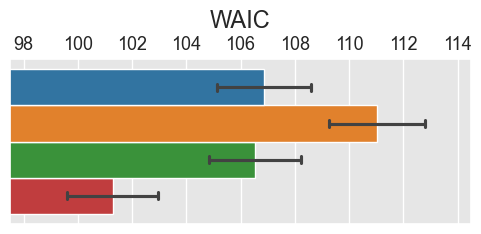

In [ ]:
# sbj-averaged model-fits (WAIC, the lower the better) all groups merged  HORIZONTAL
fig = plt.figure(figsize=(5,2.5));

# set plotting params
sns.set_theme()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette("tab10")
palette_colors = sns.color_palette("tab10")
plt.rcParams.update({'axes.titlesize':  17,
                     'axes.labelsize': 17,
                     'xtick.labelsize': 13,
                     'ytick.labelsize': 13})


g = sns.barplot(data=df_fit_sbj, x='WAIC', hue='model', errorbar='se', capsize=.2, hue_order=model_order[::-1], legend=False, palette=reversed(palette_colors[:4]), width=1)
g.set_xlim([97.5, 114.5])
g.set_xticks(np.arange(98,115,2))
g.tick_params(axis='x', which='major', labelbottom = False, bottom=False, top = False, labeltop=True, length=0)
#g.set_xlabel('WAIC')
g.set_xlabel('')
g.set_title('WAIC')
g.set_ylabel('')
g.set_yticklabels([])
g.set_ylim([-0.57, 0.57])
#g.xaxis.set_ticks_position("top")


#sns.move_legend(g, loc="center left", bbox_to_anchor=(1.1, 0.5), labels=model_labels)

plt.tight_layout();
fig.savefig('model_fits_WAIC_overall_h.png', dpi=300, bbox_inches = 'tight');

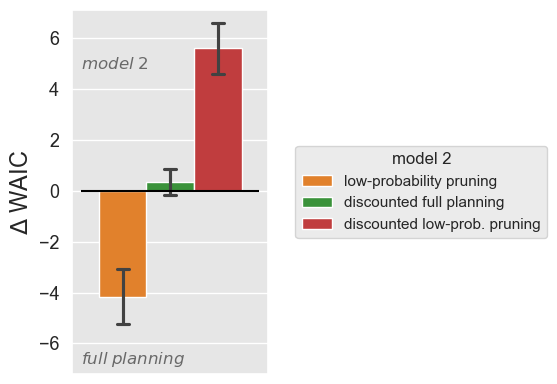

In [ ]:
# Differences of sbj-averaged WAIC values (WAIC_fullPlanning - WAIC_2)

fig = plt.figure(figsize=(6,4))

n_models = len(model_order)

g = sns.barplot(data=df_fit_sbj_diffs[df_fit_sbj_diffs.group.isin(fit_groups)], y='WAIC_Diff_m1-m2', hue='model2',  errorbar='se', capsize=.2, hue_order=model_order[1:], palette=palette_colors[1:n_models])
xmin, xmax = g.get_xlim()
g.hlines(0, xmin, xmax, colors='black')

g.set_yticks(np.arange(-6,7.5,2))
g.set_ylim(-7.2,7.1)
g.set_ylabel(r'$\Delta$ WAIC')
g.text(-0.5,4.8,  r'$\it{model}$'+' '+r'$\it{2}$', color='dimgray')
g.text(-0.5,-6.8, r'$\it{full}$'+' '+r'$\it{planning}$', color='dimgray')


sns.move_legend(g, loc="center left", bbox_to_anchor=(1.1, 0.5), title="model 2", labels=model_labels[1:])

plt.tight_layout()
#fig.savefig('model_fits_WAIC_overall_diffs.png', dpi=300, bbox_inches = 'tight')

In [15]:
df_fit_sbj_diffs[df_fit_sbj_diffs.group.isin(fit_groups)].groupby('model2').agg({'WAIC_Diff_m1-m2': ['mean', 'sem']})

WAIC_Diff_m1-m2          
                                        mean       sem
model2                                                
discounted full planning            0.328693  0.509807
discounted low-prob. pruning        5.594522  1.008103
low-probability pruning            -4.155814  1.070575